# Serie elegida, Precios promedios del combustible Superior en Guatemala de 2021-2025

Previamente se realizó una serie de tiempo para el precio diario de la gasolina en Guatemala. La idea es mejorar el modelo realizado pero ahora usando LSTM. Se ralizaran 2 modelos para esta serie previamente analizada. Los datos son exactamente los mismos y la idea es comparar el desempeño de la serie anterior con el LTS nuevo. La primera parte del análisis es la misma que en la práctica anterior, ver la estacionalidad, diferenciaciones etc.



In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

#Tensorflow
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential,save_model,load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.metrics import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import keras
import seaborn as sns

In [50]:
import pandas as pd

# funcion para procesar los libros de excel
def load_year_data(year, table_header_start, last_row):
    df = pd.read_excel('Datos_precios/Precios-Promedio-Nacionales-Diarios-2025-1.xlsx',
                       sheet_name=str(year),
                       header= table_header_start,
                       usecols=['FECHA', 'Superior'])
    
    # todos los archivos tienen una linea extra entre el encabezado y los datos
    df = df.iloc[1:last_row]
    
    # Convertir fecha y asegurar formato correcto
    df['FECHA'] = pd.to_datetime(df['FECHA'])
    df['Superior'] = pd.to_numeric(df['Superior'], errors='coerce')
    
    return df

df_2021 = load_year_data("2021", 6, 366)
df_2022 = load_year_data("2022", 6, 366)
df_2023 = load_year_data("2023", 7, 366)
df_2024 = load_year_data("2024", 7, 367)
df_2025 = load_year_data("2025", 7, 195)


## Ahora que ya se tienen los datos de los años de 2021 a 2025. Es necesario juntarlos

In [51]:
# Combinar todos los DataFrames en uno solo
df_completo = pd.concat([df_2021, df_2022, df_2023, df_2024, df_2025], ignore_index=True)

# Ordenar por fecha
df_completo = df_completo.sort_values('FECHA').reset_index(drop=True)

# Ver resultado
print("Primeras filas:")
print(df_completo.head())
print("\nÚltimas filas:")
print(df_completo.tail())
print(f"\nRango de fechas: {df_completo['FECHA'].min()} a {df_completo['FECHA'].max()}")
print(f"Total de registros: {len(df_completo)}")

Primeras filas:
       FECHA  Superior
0 2021-01-01     21.91
1 2021-01-02     21.91
2 2021-01-03     21.91
3 2021-01-04     21.91
4 2021-01-05     21.91

Últimas filas:
          FECHA  Superior
1650 2025-07-09     30.98
1651 2025-07-10     30.98
1652 2025-07-11     30.98
1653 2025-07-12     30.98
1654 2025-07-13     30.98

Rango de fechas: 2021-01-01 00:00:00 a 2025-07-13 00:00:00
Total de registros: 1655


# Analisis exploratorio del set completo

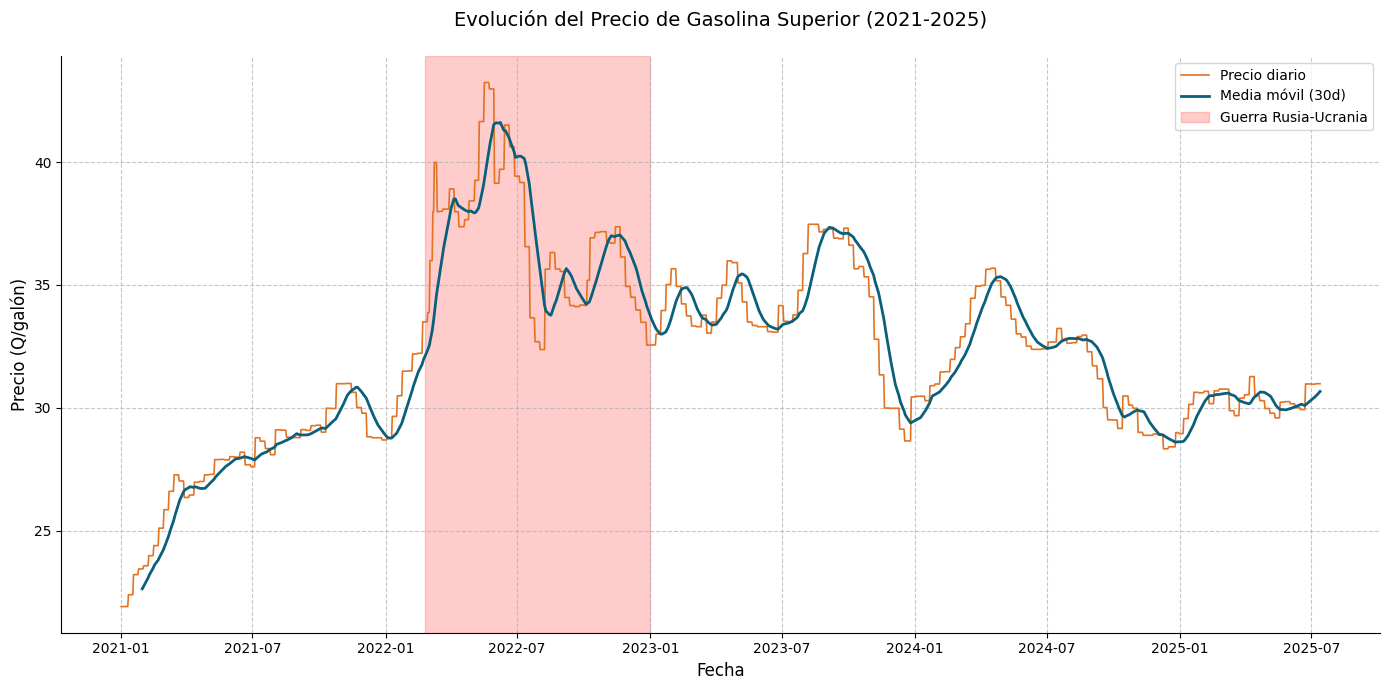

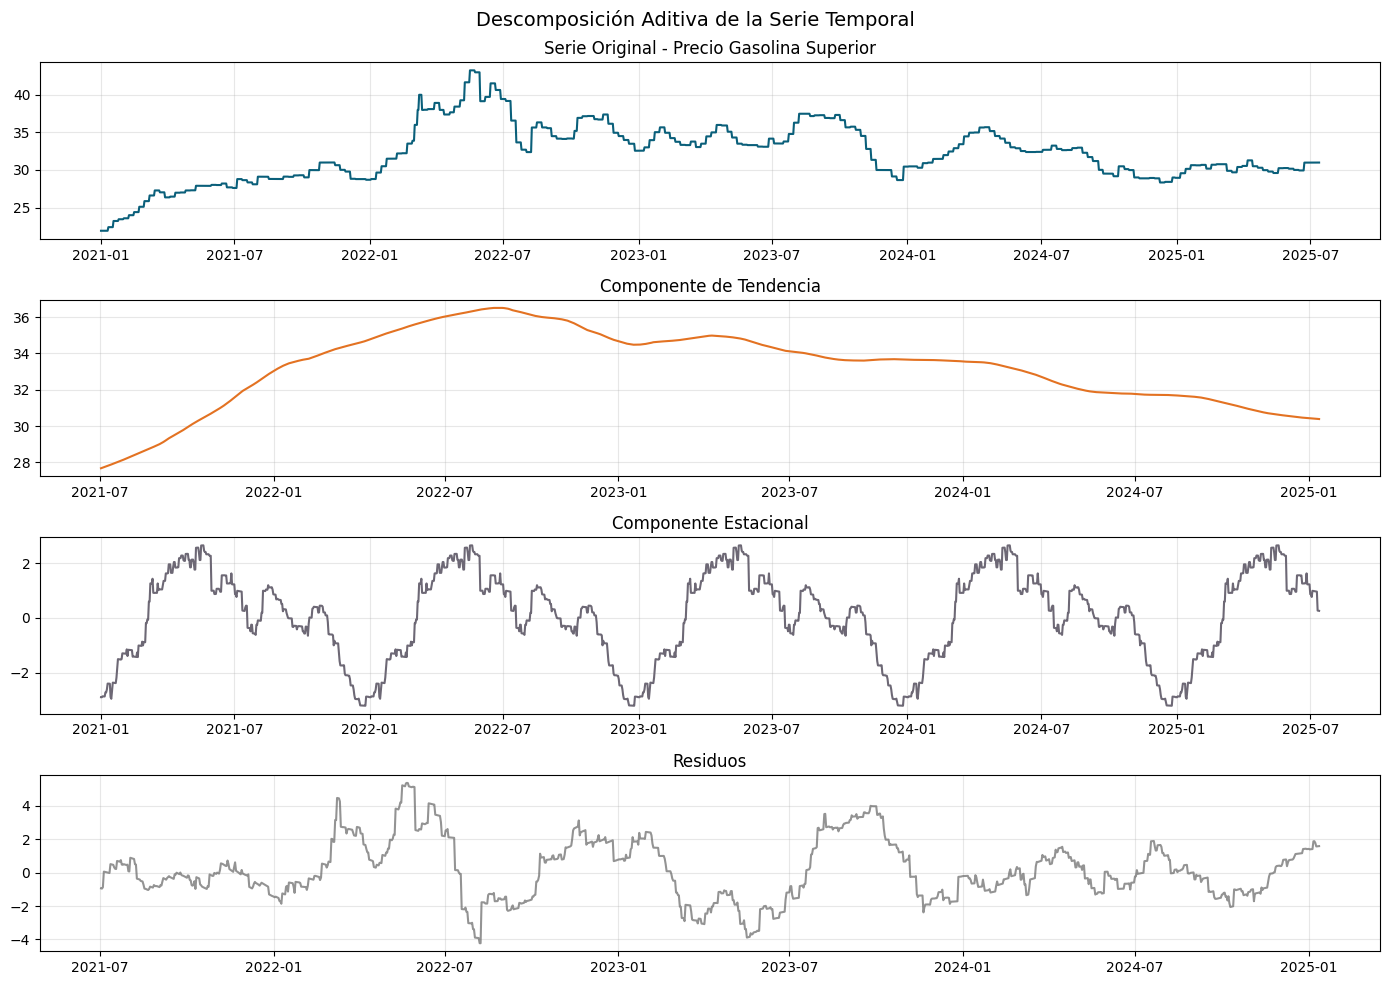

In [52]:
plt.figure(figsize=(14, 7))

# Opción 1: Línea simple
plt.plot(df_completo['FECHA'], df_completo['Superior'], 
         color='#E37222', linewidth=1.2, label='Precio diario')

# Opción 2: Promedio móvil (suaviza la serie)
window_size = 30  # Promedio de 30 días
plt.plot(df_completo['FECHA'], df_completo['Superior'].rolling(window_size).mean(), 
         color='#0A5F7A', linewidth=2, label=f'Media móvil ({window_size}d)')

# Destacar eventos importantes
plt.axvspan(pd.to_datetime('2022-02-24'), pd.to_datetime('2022-12-31'), 
            alpha=0.2, color='red', label='Guerra Rusia-Ucrania')

plt.title('Evolución del Precio de Gasolina Superior (2021-2025)\n', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio (Q/galón)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()



# Configurar la serie temporal (asegurando frecuencia diaria)
ts = df_completo.set_index('FECHA')['Superior'].asfreq('D').interpolate()

# Descomposición aditiva (modelo alternativo: multiplicative)
result = seasonal_decompose(ts, model='additive', period=365)

# Visualización mejorada
plt.figure(figsize=(14, 10))

# Serie Original
plt.subplot(4, 1, 1)
plt.plot(result.observed, color='#0A5F7A')
plt.title('Serie Original - Precio Gasolina Superior', fontsize=12)
plt.grid(alpha=0.3)

# Tendencia
plt.subplot(4, 1, 2)
plt.plot(result.trend, color='#E37222')
plt.title('Componente de Tendencia', fontsize=12)
plt.grid(alpha=0.3)

# Estacionalidad
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, color='#6D6875')
plt.title('Componente Estacional', fontsize=12)
plt.grid(alpha=0.3)

# Residuos
plt.subplot(4, 1, 4)
plt.plot(result.resid, color='#666666', alpha=0.7)
plt.title('Residuos', fontsize=12)
plt.grid(alpha=0.3)

plt.suptitle('Descomposición Aditiva de la Serie Temporal', fontsize=14)
plt.tight_layout()
plt.show()

# Análisis de estacionalidad

Se ve claramente que hay estacionalidad en el set de datos. La estacionalidad es de aproximadamente 1 año. La forma de la gráfica se repite cada año/cada 12 meses. 


# Analisis de estacionariedad

Previamente se demostró que aunque la serie parece no ser estacionaria, la prueba de Dickey FUller Aumentada muestra que no es necesario diferenciar.

In [53]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(ts, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          -3.097852
p-value                         0.026713
# de retardos usados            7.000000
# de observaciones usadas    1647.000000
Critical Value (1%)            -3.434327
Critical Value (5%)            -2.863296
Critical Value (10%)           -2.567705
dtype: float64


Realmente parece no haber mucha diferencia con la serie original a primera vista y por la prueba de Dickey-Fuller Aumentada podemos ver que en efecto la seria es estacionaria incluso antes de la transformación. Las diferenciaciones óptimas son 0 (d = 0) para el arima. Con esto podemos concluir que aunque visualmente no es estacionaria la serie, realmente la desviaciones en media y varianza resultan no ser tan significativas. Ya que incluso luego de la transformación la gráfica parece no cambiar mucho. 

Sabiendo que no es necesario diferenciar la serie, entonces se puede proceder con la transformación de los datos para ser usados por una red neuronal. Usaremos el set de datos "ts", el que no esta transformado, ni diferenciado, ya que pasó la prueba del p-value.

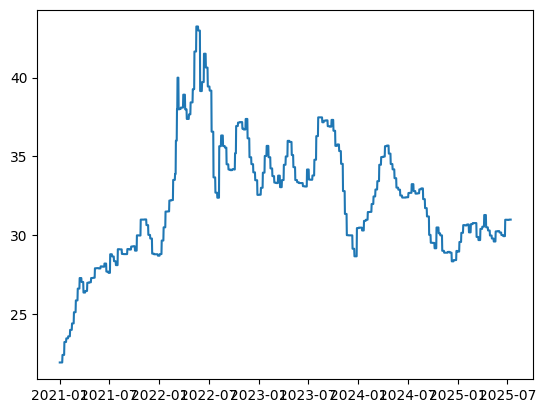

In [54]:
plt.plot(ts)

In [55]:
ts

FECHA
2021-01-01    21.91
2021-01-02    21.91
2021-01-03    21.91
2021-01-04    21.91
2021-01-05    21.91
              ...  
2025-07-09    30.98
2025-07-10    30.98
2025-07-11    30.98
2025-07-12    30.98
2025-07-13    30.98
Freq: D, Name: Superior, Length: 1655, dtype: float64

In [56]:
scaler = StandardScaler()
ts_reset = ts.reset_index()  # Convierte 'FECHA' de nuevo en columna
ts_reset['Superior_scaled'] = scaler.fit_transform(ts_reset[['Superior']])

ts_reset = ts_reset.set_index('FECHA')
print(ts_reset.head())

            Superior  Superior_scaled
FECHA                                
2021-01-01     21.91        -2.683439
2021-01-02     21.91        -2.683439
2021-01-03     21.91        -2.683439
2021-01-04     21.91        -2.683439
2021-01-05     21.91        -2.683439


# Separación de los datos
Al igual que en el caso de la predicción con los modelos ARIMA y SARIMAX, se tomaran 3 años previos (2022-2024) como entrenamiento y test como la información que se tiene hasta el momento de 2025. Aunque con la ligera diferencia que ahora tambien es necesario tener en cuenta el validation y no solo test.

In [57]:
train = ts_reset['2022-01-01':'2023-12-31']
validation = ts_reset['2024-01-01':'2024-12-31']
test = ts_reset['2025-01-01':]

print(f"Train: {train.shape[0]} puntos ({train.index.min()} a {train.index.max()})")
print(f"Validation: {validation.shape[0]} puntos ({validation.index.min()} a {validation.index.max()})")
print(f"Test: {test.shape[0]} puntos ({test.index.min()} to {test.index.max()})")

Train: 730 puntos (2022-01-01 00:00:00 a 2023-12-31 00:00:00)
Validation: 366 puntos (2024-01-01 00:00:00 a 2024-12-31 00:00:00)
Test: 194 puntos (2025-01-01 00:00:00 to 2025-07-13 00:00:00)


Para que pueda usarse el argoritmo LSTM es necesario transformar la serie en una supervisada, de manera que las observaciones anteriores sean capaces de estimar la siguiente. En este caso vamos a usar el mes anterior para predecir el siguiente por lo que vamos a transformar el arreglo de numpy en una matriz de dos dimensiones en la que la dimensión 1 sea el instante t-1 y la dimensión 2 sea el instante t

In [58]:
import numpy as np

def supervisada(serie, retrasos=30):  # 30 para usar ventana de 30 días
    serie_x = []
    serie_y = []
    serie_array = serie.values if isinstance(serie, pd.DataFrame) else serie
    for i in range(len(serie_array) - retrasos):
        valor = serie_array[i:(i + retrasos)]
        valor_sig = serie_array[i + retrasos]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

# superior escaled es la columna con el precio del galon escalado
# para que sea procesado mejor por la red neuronal

x_train, y_train = supervisada(train[['Superior_scaled']]) 
x_val, y_val = supervisada(validation[['Superior_scaled']])
x_test, y_test = supervisada(test[['Superior_scaled']])

# Verificamos formas
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}") 
print(train[0:6])
print(x_train[0:6])
print(y_train[0:6])


x_train shape: (700, 30, 1)
y_train shape: (700, 1)
            Superior  Superior_scaled
FECHA                                
2022-01-01     28.69        -0.906560
2022-01-02     28.69        -0.906560
2022-01-03     28.79        -0.880352
2022-01-04     28.79        -0.880352
2022-01-05     28.79        -0.880352
2022-01-06     28.79        -0.880352
[[[-0.90655988]
  [-0.90655988]
  [-0.88035223]
  [-0.88035223]
  [-0.88035223]
  [-0.88035223]
  [-0.88035223]
  [-0.88035223]
  [-0.88035223]
  [-0.65496643]
  [-0.65496643]
  [-0.65496643]
  [-0.65496643]
  [-0.65496643]
  [-0.65496643]
  [-0.65496643]
  [-0.43482215]
  [-0.43482215]
  [-0.43482215]
  [-0.43482215]
  [-0.43482215]
  [-0.43482215]
  [-0.43482215]
  [-0.17274564]
  [-0.17274564]
  [-0.17274564]
  [-0.17274564]
  [-0.17274564]
  [-0.17274564]
  [-0.17274564]]

 [[-0.90655988]
  [-0.88035223]
  [-0.88035223]
  [-0.88035223]
  [-0.88035223]
  [-0.88035223]
  [-0.88035223]
  [-0.88035223]
  [-0.65496643]
  [-0.65496643]
  


## Creando el modelo
Para que pueda hacerse el modelo se le tiene que suministrar una matriz de 3 dimensiones siendo estas:
- ***Muestras:*** número de observaciones en cada lote, también conocido como tamaño del lote.
- ***Pasos de tiempo:*** Pasos de tiempo separados para una observación dada. En este ejemplo los pasos de tiempo = 1
- ***Características:*** Para un caso univariante, como en este ejemplo, las características = 1  

Un modelo LSTM permite ingresar datos a una red y hacer predicciones basados en pasos individuales de datos secuenciales. Como es una serie de tiempo donde queremos predecir el próximo elemento, usaremos un modelo secuencial, para predecir el próximo elemento, por esto es que el paso es 1.

El número de neuronas en la capa de salida (Dense) debe estar en la forma en que necesitamos la salida, en el caso de las series de tiempo necesitamos una neurona porque queremos predecir un valor. 

Vamos a convertir los conjuntos en matrices de 3 dimensiones __(Texto extraido del ejemplo de clase)__ :

# Creación del primer modelo (1 CAPA) usando tensorflow

In [59]:
lote = 32  # en lugar de 1
unidades = 50  # en lugar de 1
paso = 30  # en lugar de 1 (usar ventana de 30 días)
epocas = 50  # en lugar de 10
learning_rate = 0.001  # en lugar de 0.1

x_train = np.reshape(x_train, (x_train.shape[0], paso, 1))  
x_val = np.reshape(x_val, (x_val.shape[0], paso, 1))
x_test = np.reshape(x_test, (x_test.shape[0], paso, 1))
len(x_val)

modelo1 = Sequential()
modelo1.add(LSTM(50, input_shape=(paso, 1)))  # Más neuronas
modelo1.add(Dense(1))

c:\Users\andre\Desktop\Chuy\CUARTO 2\DATA SCIENCE\Environments\env_tensorflow\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Compilamos el modelo. Las métricas que nos van a servir para saber como funciona el modelo en términos de la pérdida es el error medio cuadrado. 
Se le puso una detención temprana para ahorrar tiempo de entrenamiento. Para el entrenamiento del modelo cuando se da cuenta de que no habrá disminución de la pérdida en las siguientes épocas. __(Texto extraido del ejemplo de clase)__

In [60]:
#early_stop = EarlyStopping(monitor='val_loss', patience=1)
modelo1.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=0.1), metrics = [RootMeanSquaredError()])
modelo1

<Sequential name=sequential_2, built=True>

In [61]:
epocas = 10
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    #callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 4.6638 - root_mean_squared_error: 2.0720 - val_loss: 1.0732 - val_root_mean_squared_error: 1.0359
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.0177 - root_mean_squared_error: 0.9895 - val_loss: 0.0467 - val_root_mean_squared_error: 0.2160
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2600 - root_mean_squared_error: 0.5030 - val_loss: 0.0463 - val_root_mean_squared_error: 0.2152
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0897 - root_mean_squared_error: 0.2952 - val_loss: 0.0164 - val_root_mean_squared_error: 0.1280
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0362 - root_mean_squared_error: 0.1887 - val_loss: 0.0211 - val_root_mean_squared_error: 0.1451
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0352 - root_mean_squared_error: 0.1868 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1060
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss:

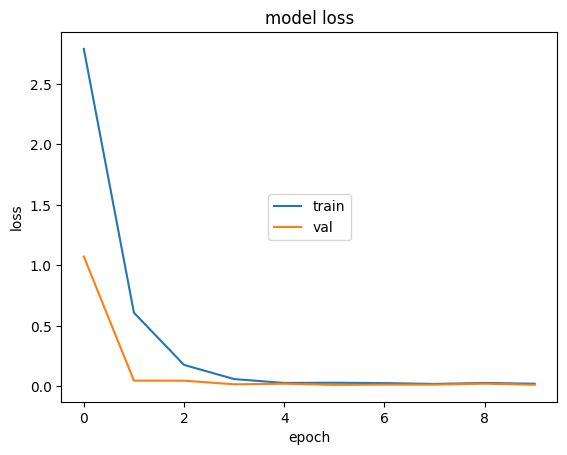

In [62]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

<Axes: >

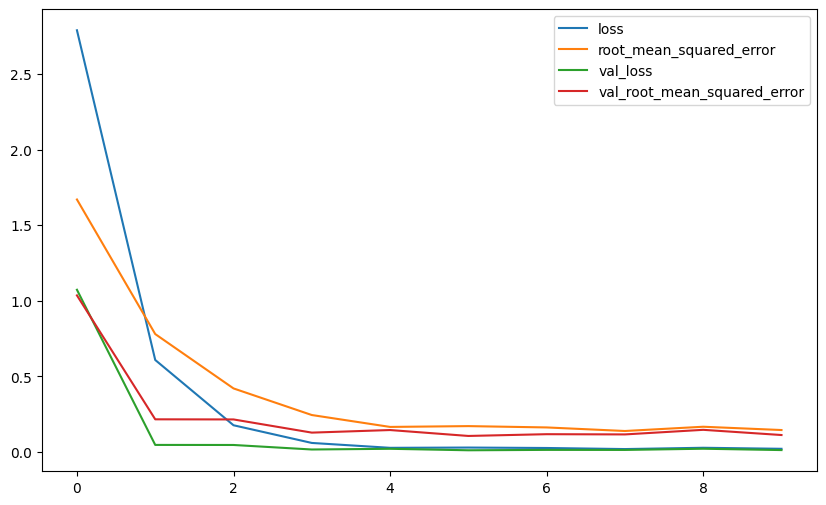

In [63]:
losses_df1 = pd.DataFrame(history.history)

losses_df1.plot(figsize = (10,6))

In [64]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0339 - root_mean_squared_error: 0.1822
Pérdida en Validación
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0079 - root_mean_squared_error: 0.0873
Pérdida en Prueba
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0088 - root_mean_squared_error: 0.0935


[0.009141870774328709, 0.09561312943696976]

# Creacion del segundo modelo (con algunos cambios de parametros)

In [ ]:


lote2 = 64
unidades2 = 100
paso2 = 14  # Ventana de 2 semanas en lugar de 1 mes
epocas2 = 100
learning_rate2 = 0.0005

# Arquitectura más profunda
modelo2 = Sequential()
modelo2.add(LSTM(100, return_sequences=True, input_shape=(paso2, 1))) 
modelo2.add(LSTM(50))  # Segunda capa LSTM
modelo2.add(Dense(1))

modelo2.compile(loss='mean_squared_error',
               optimizer=Adam(learning_rate=learning_rate2),
               metrics=[RootMeanSquaredError()])

# datos para modelo2 con ventana de 14 días
x_train2, y_train2 = supervisada(train[['Superior_scaled']], retrasos=paso2)
x_val2, y_val2 = supervisada(validation[['Superior_scaled']], retrasos=paso2)
x_test2, y_test2 = supervisada(test[['Superior_scaled']], retrasos=paso2)

x_train2 = np.reshape(x_train2, (x_train2.shape[0], paso2, 1))
x_val2 = np.reshape(x_val2, (x_val2.shape[0], paso2, 1))
x_test2 = np.reshape(x_test2, (x_test2.shape[0], paso2, 1))

# Early stopping para ambos modelos
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenamiento modelo2
history2 = modelo2.fit(
    x=x_train2,
    y=y_train2,
    batch_size=lote2,
    epochs=epocas2,
    shuffle=False,
    validation_data=(x_val2, y_val2),
    callbacks=[early_stop],
    verbose=1
)

c:\Users\andre\Desktop\Chuy\CUARTO 2\DATA SCIENCE\Environments\env_tensorflow\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 1.1961 - root_mean_squared_error: 1.0735 - val_loss: 0.0865 - val_root_mean_squared_error: 0.2940
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1916 - root_mean_squared_error: 0.4340 - val_loss: 0.0616 - val_root_mean_squared_error: 0.2482
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1192 - root_mean_squared_error: 0.3431 - val_loss: 0.0458 - val_root_mean_squared_error: 0.2139
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1359 - root_mean_squared_error: 0.3642 - val_loss: 0.0349 - val_root_mean_squared_error: 0.1869
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1079 - root_mean_squared_error: 0.3259 - val_loss: 0.0281 - val_root_mean_squared_error: 0.1677
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0962 - root_mean_squared_error: 0.3077 - val_loss: 0.0265 - val_root_mean_squared_error: 0.1628
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step 

# Comparacion de ambos modelos


=== COMPARACIÓN DE MODELOS ===

Evaluación Modelo 1 (30 días):
MSE: 0.1831
RMSE: 0.4279
MAE: 0.3445

Evaluación Modelo 2 (14 días, 2 capas):
MSE: 0.1149
RMSE: 0.3390
MAE: 0.2545


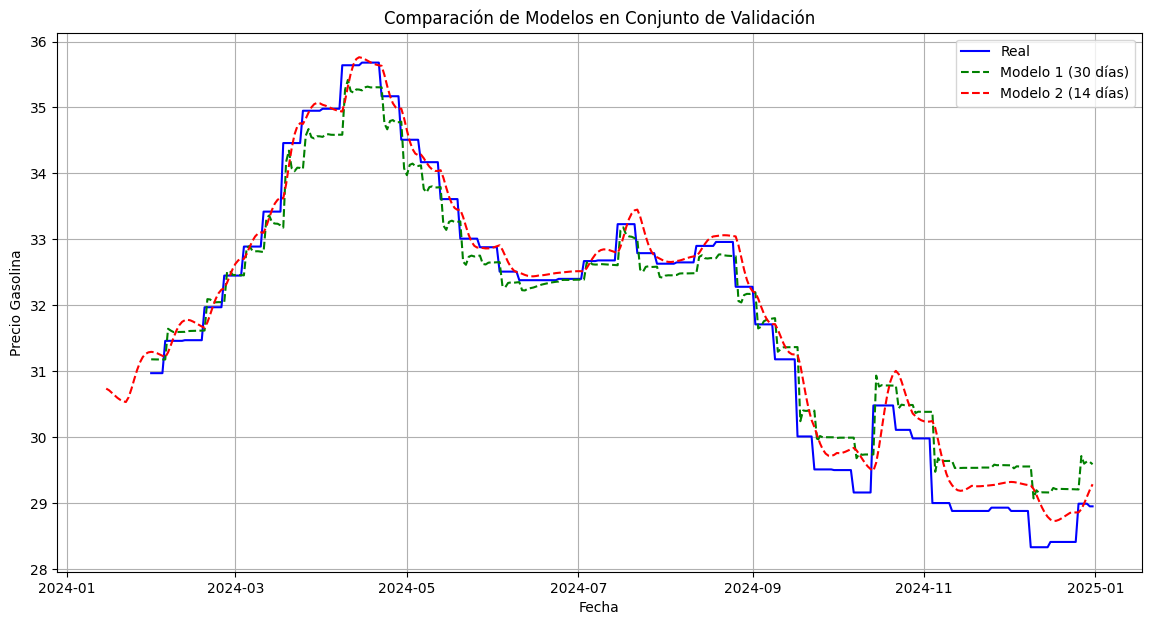

In [67]:
# --- FUNCIÓN PARA EVALUACIÓN COMPLETA (VERSIÓN CORREGIDA) ---
def evaluar_modelo(modelo, x_data, y_data, scaler, nombre_modelo, fechas):
    # Predicciones
    predicciones = []
    for i in range(len(x_data)):
        X = x_data[i].reshape(1, x_data.shape[1], 1)
        yhat = modelo.predict(X, verbose=0)
        predicciones.append(yhat[0][0])
    
    # Revertir escalado
    y_real = scaler.inverse_transform(y_data.reshape(-1, 1)).flatten()
    y_pred = scaler.inverse_transform(np.array(predicciones).reshape(-1, 1)).flatten()
    
    # Métricas
    mse = mean_squared_error(y_real, y_pred)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_real - y_pred))
    
    print(f"\nEvaluación {nombre_modelo}:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    
    return y_pred, fechas[-len(y_real):]  # Devuelve predicciones y fechas correspondientes

# Evaluar ambos modelos (versión corregida)
print("\n=== COMPARACIÓN DE MODELOS ===")

# Modelo 1 - Obtener predicciones Y fechas alineadas
y_pred_val1, fechas_val1 = evaluar_modelo(modelo1, x_val, y_val, scaler, "Modelo 1 (30 días)", validation.index)

# Modelo 2 - Obtener predicciones Y fechas alineadas
y_pred_val2, fechas_val2 = evaluar_modelo(modelo2, x_val2, y_val2, scaler, "Modelo 2 (14 días, 2 capas)", validation.index)

# Visualización comparativa (versión corregida)
plt.figure(figsize=(14, 7))
plt.plot(fechas_val1, scaler.inverse_transform(y_val.reshape(-1, 1)), label='Real', color='blue')
plt.plot(fechas_val1, y_pred_val1, label='Modelo 1 (30 días)', linestyle='--', color='green')
plt.plot(fechas_val2, y_pred_val2, label='Modelo 2 (14 días)', linestyle='--', color='red')
plt.title('Comparación de Modelos en Conjunto de Validación')
plt.xlabel('Fecha')
plt.ylabel('Precio Gasolina')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def predecir_lstm(data, modelo, scaler):
    predicciones = []
    for X in data:
        X = np.reshape(X, (1, 1, 1))  # Asegurar forma (1, 1, 1)
        yhat = modelo.predict(X, verbose=0)  # Predicción
        yhat = scaler.inverse_transform(yhat)  # Revertir escalado
        predicciones.append(yhat[0][0])
    return np.array(predicciones)

# Predicciones
prediccion_val = predecir_lstm(x_val, modelo1, scaler)
prediccion_test = predecir_lstm(x_test, modelo1, scaler)

In [ ]:
ts_reset

,Superior,Superior_scaled
FECHA,,
2021-01-01,21.91,-2.683439
2021-01-02,21.91,-2.683439
2021-01-03,21.91,-2.683439
2021-01-04,21.91,-2.683439
2021-01-05,21.91,-2.683439
...,...,...
2025-07-09,30.98,-0.306405
2025-07-10,30.98,-0.306405
2025-07-11,30.98,-0.306405


In [ ]:
print(validation.shape, x_val.shape, y_val.shape)
# Convierte el índice a columna temporalmente
ts_reset = ts_reset.reset_index()  
print(ts_reset.columns)  # Lista todas las columnas disponibles

(366, 2) (365, 1, 1) (365, 1)
Index(['FECHA', 'Superior', 'Superior_scaled'], dtype='object')


In [ ]:
prediccion_val

array([30.703741, 30.703741, 30.745667, 30.745667, 30.745667, 30.745667,
       30.745667, 30.745667, 30.745667, 30.745667, 30.745667, 30.745667,
       30.745667, 30.745667, 30.4907  , 30.4907  , 30.4907  , 30.4907  ,
       30.4907  , 30.4907  , 30.4907  , 31.322655, 31.322655, 31.322655,
       31.322655, 31.322655, 31.322655, 31.322655, 31.412539, 31.412539,
       31.412539, 31.412539, 31.412539, 31.412539, 31.412539, 32.013382,
       32.013382, 32.013382, 32.013382, 32.013382, 32.013382, 32.013382,
       32.025166, 32.025166, 32.025166, 32.025166, 32.025166, 32.025166,
       32.025166, 32.59385 , 32.59385 , 32.59385 , 32.59385 , 32.59385 ,
       32.59385 , 32.59385 , 33.108265, 33.108265, 33.108265, 33.108265,
       33.108265, 33.108265, 33.108265, 33.559372, 33.559372, 33.559372,
       33.559372, 33.559372, 33.559372, 33.559372, 34.08212 , 34.08212 ,
       34.08212 , 34.08212 , 34.08212 , 34.08212 , 34.08212 , 35.04811 ,
       35.04811 , 35.04811 , 35.04811 , 35.04811 , 

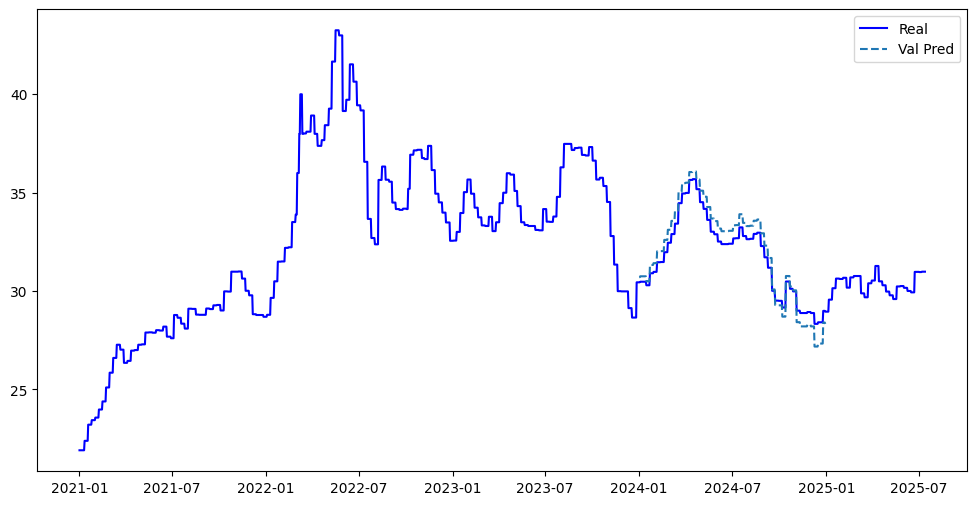

In [ ]:
# 1. Asegurar que validation tenga el mismo tamaño que x_val
validation = validation.iloc[:len(x_val)]

# 2. Crear DataFrame con índices alineados
df_val_pred = pd.DataFrame(prediccion_val, 
                          index=validation.index, 
                          columns=['Predicción_Val'])

# 3. Graficar (ahora con tamaños compatibles)
plt.figure(figsize=(12, 6))
plt.plot(ts_reset['FECHA'], ts_reset['Superior'], label='Real', color='blue')
plt.plot(df_val_pred.index, df_val_pred['Predicción_Val'], label='Val Pred', linestyle='--')
plt.legend()
plt.show()